In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


def detect_kick_onsets_baseline(path,
sr=44100,
hop_length=512,
lowpass_hz=300,
min_lowband_rms=0.02,
onset_backtrack=True):

    # 1) Load mono audio
    y, sr = librosa.load(path, sr=sr, mono=True)

    # 2) HPSS: emphasize percussive content
    y_harm, y_perc = librosa.effects.hpss(y)

    # 3) Optional: simple low-pass filter to focus on kick band
    # Using a short FIR via librosa's effects.preemphasis is awkward here,
    # so simplest is to design a small low-pass via librosa's cqt or your own filter.
    # For a quick hack, downsample-style: just compute onset strength from a low band.

    # 3a) Compute mel spectrogram and restrict to low mel bins
    S = librosa.feature.melspectrogram(
        y=y_perc, sr=sr, n_fft=2048, hop_length=hop_length,
        n_mels=64, fmax=lowpass_hz
    )
    o_env = librosa.onset.onset_strength(
        S=librosa.power_to_db(S), sr=sr, hop_length=hop_length
    )

    # 4) Detect onsets in time
    onsets = librosa.onset.onset_detect(
        onset_envelope=o_env,
        sr=sr,
        hop_length=hop_length,
        units='time',
        backtrack=onset_backtrack,
    )

    # 5) Low-band energy check to keep only strong kicks
    win = int(0.06 * sr)  # 60 ms around each onset
    kept = []
    for t in onsets:
        c = int(t * sr)
        s = max(0, c - win // 2)
        e = min(len(y_perc), c + win // 2)
        seg = y_perc[s:e]
        if len(seg) == 0:
            continue
        rms = np.sqrt(np.mean(seg**2))
        if rms >= min_lowband_rms:
            kept.append(t)

    return np.array(kept), sr


In [11]:
track = Path('../data/tracks/Deezl - GHOST.wav')

onset_times, sr = detect_kick_onsets_baseline(track)



c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


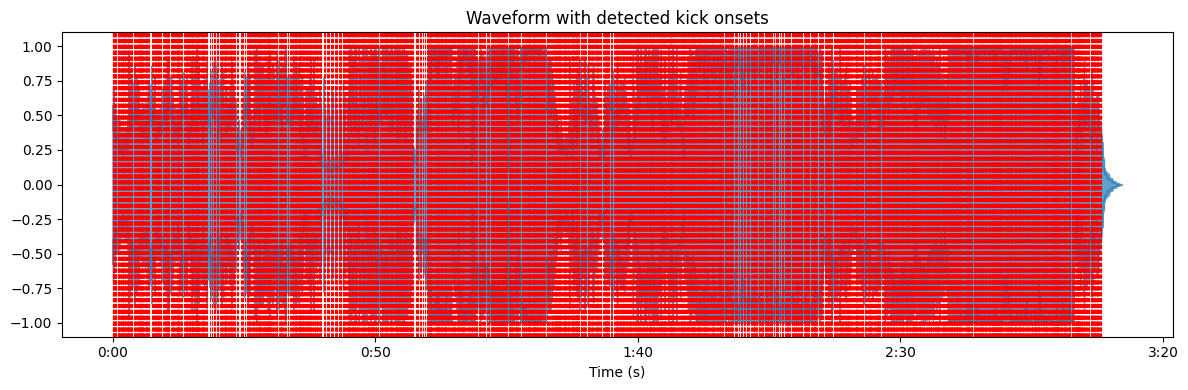

In [13]:
y, sr = librosa.load(track, sr=sr, mono=True)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.7) # time-axis waveform​

for t in onset_times:
    plt.axvline(x=t, color='r', linestyle='--', linewidth=0.8) # vertical lines at onsets​

plt.title('Waveform with detected kick onsets')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

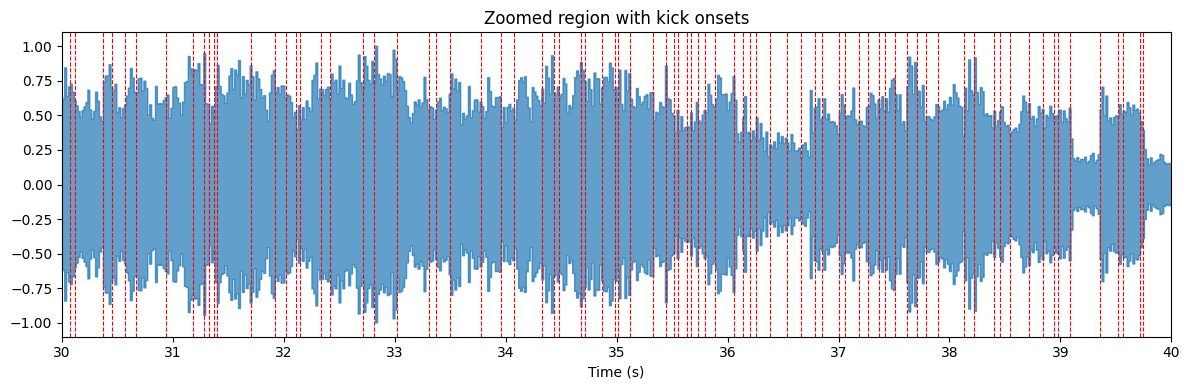

In [14]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.7)
for t in onset_times:
    plt.axvline(x=t, color='r', linestyle='--', linewidth=0.8)
plt.xlim(30, 40) # show 30–40 seconds, adjust as needed
plt.title('Zoomed region with kick onsets')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()